<h2 style="text-align:center;" > Estudio de viabilidad en la delimitación de coberturas con imágenes satelitales mediante el modelo Segment Anything: Comparación con la metodología CORINE Land Cover en el municipio de Guatavita.</h2>

<h2 style="text-align:center;" >Tutorial: Segmentacion automatica</h2>

Autores:
*   **Cristian Stiven Florez Macias**
*   **Sergio Andres Escobar Eslava** 

## Instalar Librerias

* **Torch**:
* **SAMGEO**:

In [36]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install segment-geospatial
!pip install segment-anything-hq

Looking in indexes: https://download.pytorch.org/whl/cu118


In [37]:
import rasterio as rio
import matplotlib.pyplot as plt
import numpy as np
from rasterio.plot import show
import cv2
import torch
from samgeo.hq_sam import (
    SamGeo
)
from segment_anything_hq import sam_model_registry , SamAutomaticMaskGenerator
import geopandas as gpd
from shapely.geometry import shape, MultiPolygon
from rasterio.features import shapes
import rasterio
import pandas as pd
from shapely.ops import unary_union

In [4]:
## verificamos instalacion de pytorch y cuda
print(f"Version PyTorch : {torch.__version__}")
print(f"Version CUDA : {torch.version.cuda}")


Version PyTorch : 2.7.1+cu118
Version CUDA : 11.8


## Cargar la imagen a segmentar

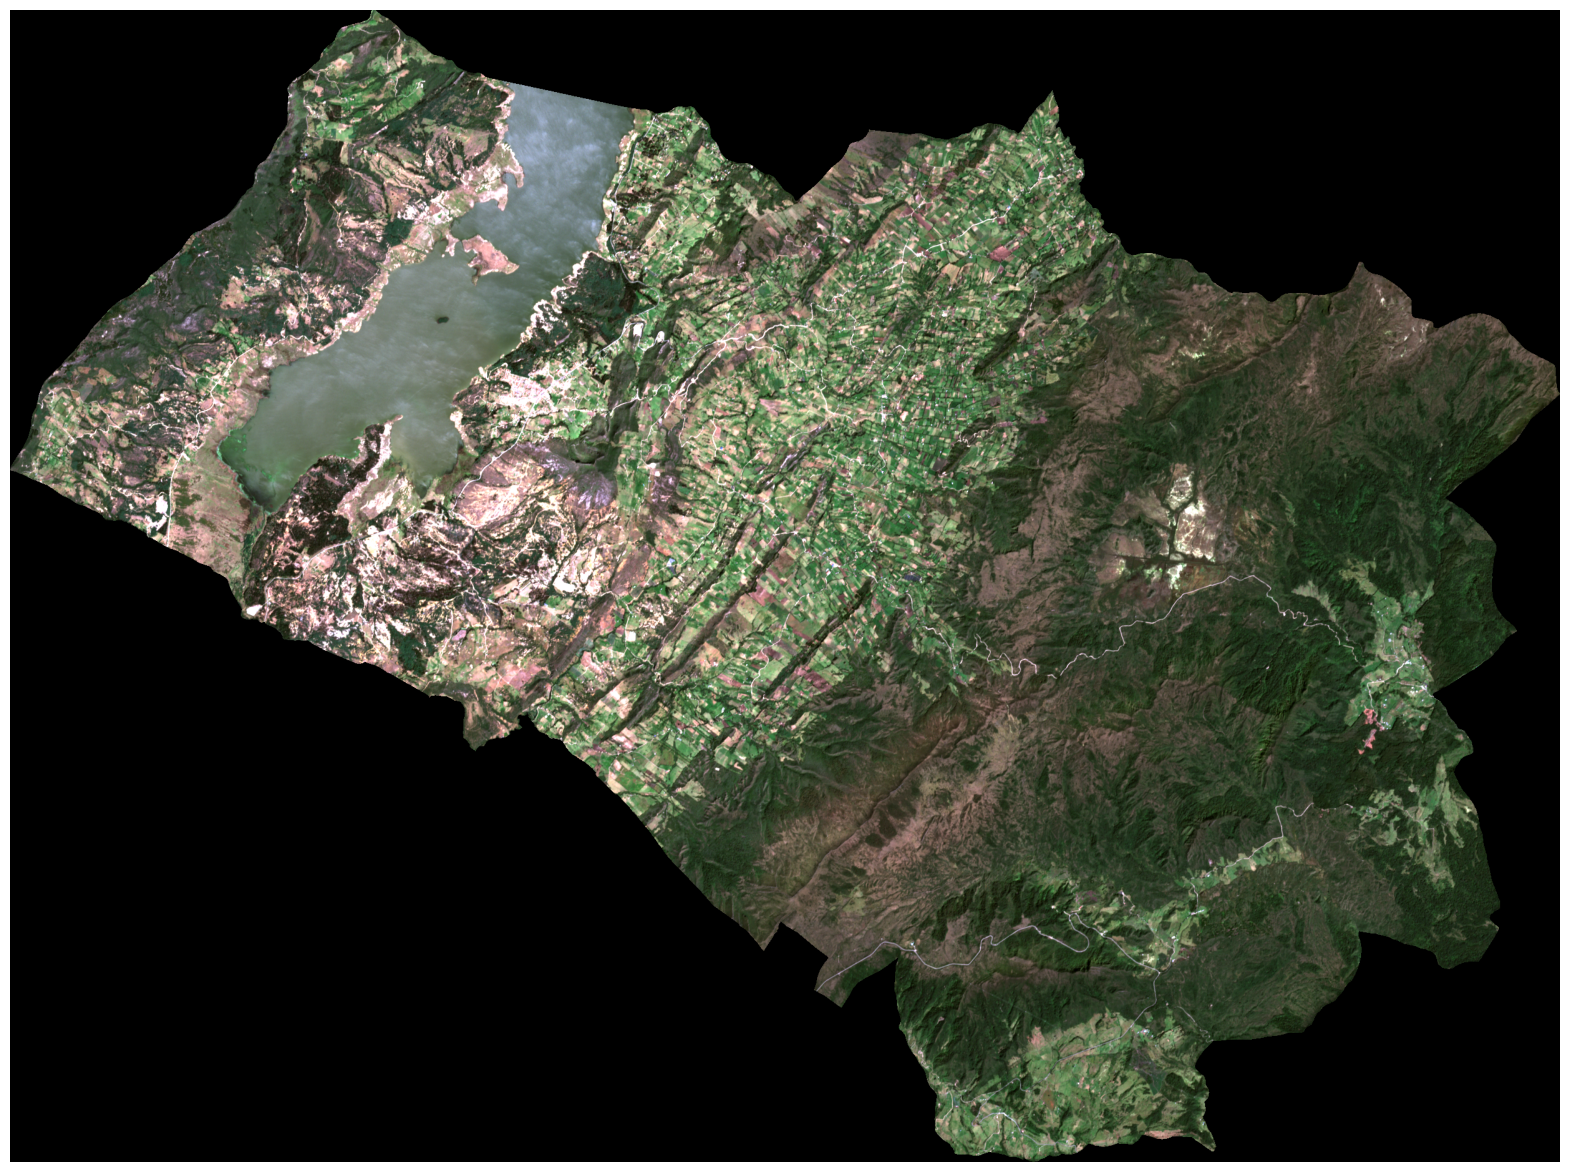

In [5]:
image = cv2.imread('../tiff/sentinel_guatavita_realzada.tif')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(20,20))
plt.imshow(image)
plt.axis('off')
plt.show()

## Inicializar el modelo GeoSAM

In [ ]:
sam = SamGeo(
    device="cuda",
    hq=True,
    model_type="vit_h",
    checkpoint_dir="../model",
    sam_kwargs={
        "points_per_side": 256,
        "points_per_batch": 64,
        "pred_iou_thresh": 0.5,
        "stability_score_thresh": 0.5,
        "stability_score_offset": 1.0,
        "box_nms_thresh": 0.7,
        "crop_n_layers": 2,
        "crop_nms_thresh": 0.7,
        "crop_overlap_ratio": 0.3,
        "crop_n_points_downscale_factor": 2,
        "point_grids": None,
        "min_mask_region_area": 10,
        "output_mode": "binary_mask"
    },
)

## Inicializar el modelo SAMHQ

In [40]:
sam_checkpoint = "../model/sam_hq_vit_h.pth"
model_type = "vit_h"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device="cuda")

mask_generator = SamAutomaticMaskGenerator(
            model=sam,
            points_per_side= 324,
            pred_iou_thresh= 0.5,
            stability_score_thresh= 0.2,
            crop_n_layers= 0,
            crop_n_points_downscale_factor= 0,
            min_mask_region_area= 100
)

<All keys matched successfully>


In [41]:
masks = mask_generator.generate(image)


CRSError: The EPSG code is unknown. PROJ: proj_create_from_database: C:\Program Files\PostgreSQL\17\share\contrib\postgis-3.5\proj\proj.db contains DATABASE.LAYOUT.VERSION.MINOR = 2 whereas a number >= 4 is expected. It comes from another PROJ installation.

## Visualizar resultado

c:\Users\Cristian\Desktop\Trabajos U\DEFINITIVO-Proyecto de grado\.venv\Lib\site-packages\rasterio\__init__.py:378: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = writer(


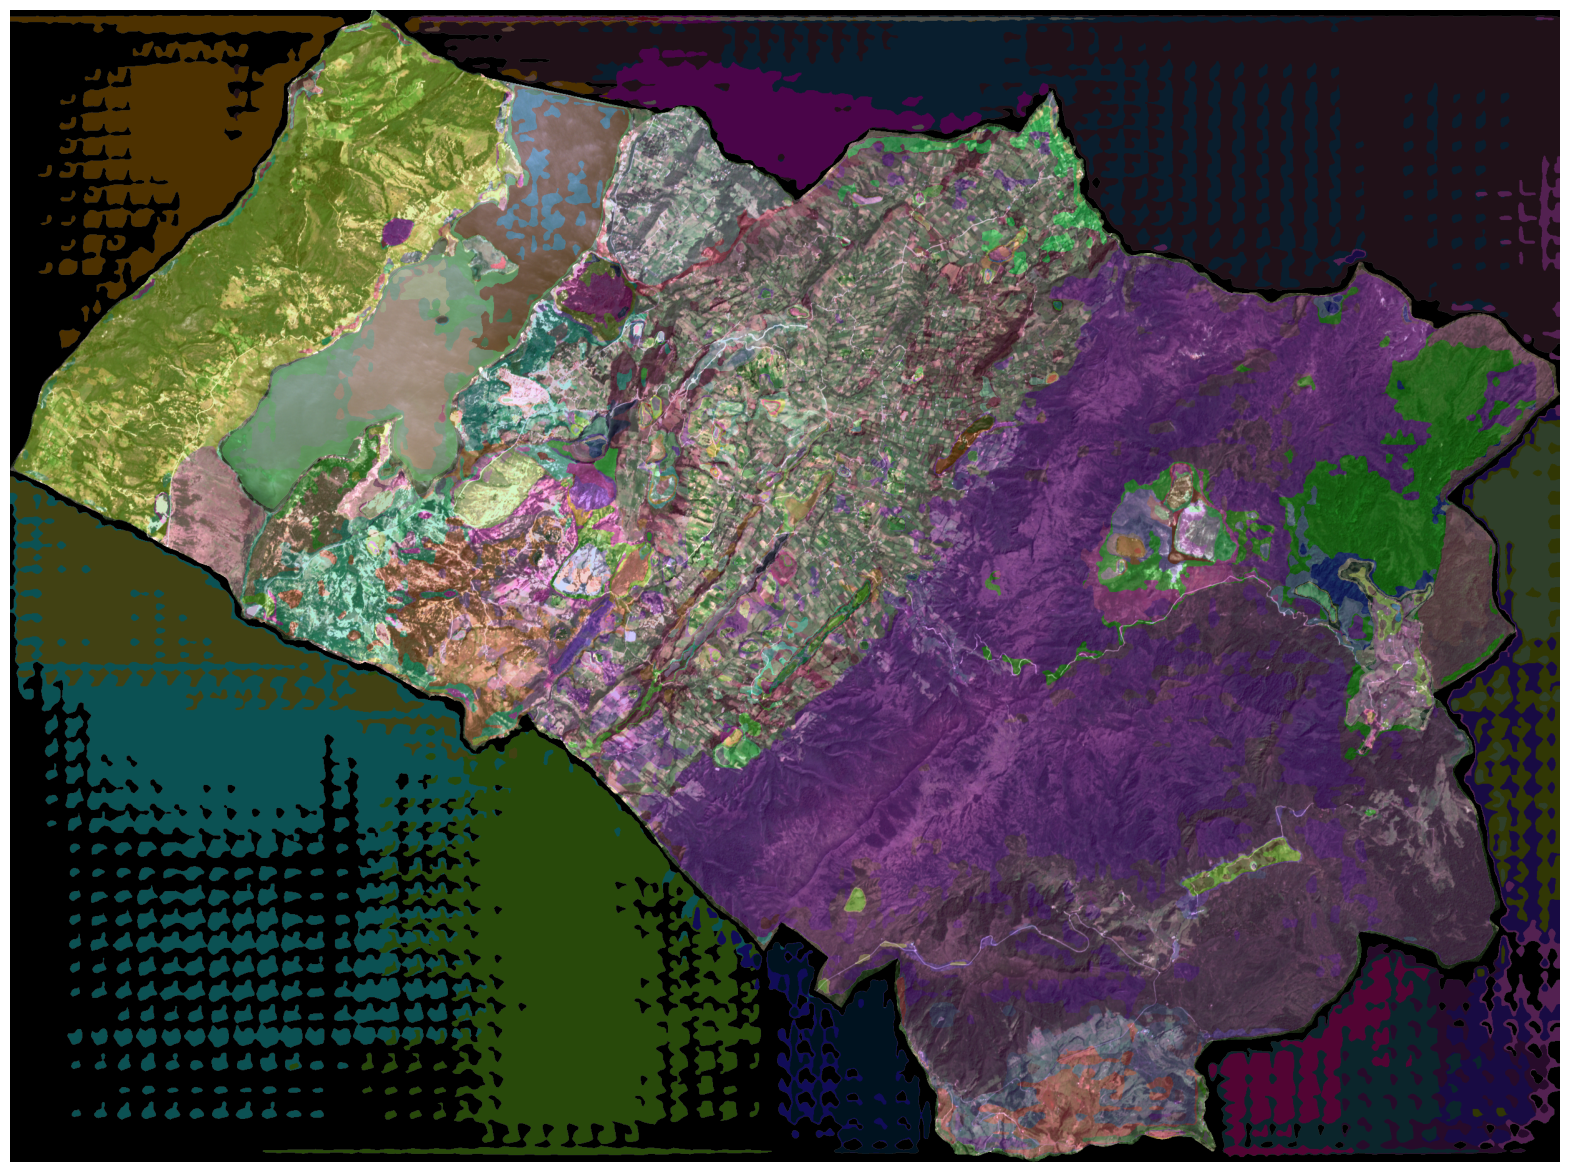

In [ ]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    
    # Convert to uint8 and scale to 0-255 range
    img_rgb = (img[:,:,:3] * 255).astype('uint8')
    ## Exportar imagen
    with rasterio.open(
        '../tiff/segmentacion_automatica.tiff',
        'w',
        driver='GTiff',
        height=img.shape[0],
        width=img.shape[1],
        count=3,
        dtype='uint8',
        compress='lzw'
    ) as dst:
        # Guardar cada banda por separado
        dst.write(img_rgb[:,:,0], 1)  # Banda roja
        dst.write(img_rgb[:,:,1], 2)  # Banda verde
        dst.write(img_rgb[:,:,2], 3)  # Banda azul
    ax.imshow(img)

plt.figure(figsize=(20,20))
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()